In [1]:
##libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt

station measureDate  StaGrpCode         StaType Transect   Latitude  \
0         CM  2004-09-30         2.0  Mainland Creek   Oyster  37.287616   
1         CM  2004-10-26         2.0  Mainland Creek   Oyster  37.287616   
2         CM  2004-11-10         2.0  Mainland Creek   Oyster  37.287616   
3         CM  2004-12-08         2.0  Mainland Creek   Oyster  37.287616   
4         CM  2005-02-09         2.0  Mainland Creek   Oyster  37.287616   
...      ...         ...         ...             ...      ...        ...   
2536     CRM  2019-10-15         NaN             NaN      NaN        NaN   
2537     NaN  2017-04-27         NaN             NaN      NaN        NaN   
2538     NaN  2017-08-21         NaN             NaN      NaN        NaN   
2539     NaN  2017-12-04         NaN             NaN      NaN        NaN   
2540     NaN  2017-12-05         NaN             NaN      NaN        NaN   

      Longitude    time  analyst tidestage  ...  sedMassqual  sedperc_N  \
0     -75.92876  1345.0      ART  LATE EBB  ...            M        NaN   
1     -75.92876  1100.0   KMO/AS   MID EBB  ...            M        NaN   
2     -75.92876   950.0   KMO/AS   MID EBB  ...            M        NaN   
3     -75.92876   855.0      ART   MID EBB  ...            M        NaN   
4     -75.92876  1205.0  KMO/ART   MID EBB  ...            M        NaN   
...         ...     ...      ...       ...  ...          ...        ...   
2536        NaN     NaN      NaN       NaN  ...            M        NaN   
2537        NaN     NaN      NaN       NaN  ...            M        NaN   
2538        NaN     NaN      NaN       NaN  ...            M        NaN   
2539        NaN     NaN      NaN       NaN  ...            M        NaN   
2540        NaN     NaN      NaN       NaN  ...            M        NaN   

      sedperc_N_sd  sedperc_N_N  sedperc_Nqual  sedperc_C  sedperc_C_sd  \
0              NaN          NaN              M        NaN           NaN   
1              NaN          NaN              M        NaN           NaN   
2              NaN          NaN              M        NaN           NaN   
3              NaN          NaN              M        NaN           NaN   
4              NaN          NaN              M        NaN           NaN   
...            ...          ...            ...        ...           ...   
2536           NaN          NaN              M        NaN           NaN   
2537           NaN          NaN              M        NaN           NaN   
2538           NaN          NaN              M        NaN           NaN   
2539           NaN          NaN              M        NaN           NaN   
2540           NaN          NaN              M        NaN           NaN   

      sedperc_C_N  sedperc_Cqual commentSedCN  
0             NaN              M          NaN  
1             NaN              M          NaN  
2             NaN              M          NaN  
3             NaN              M          NaN  
4             NaN              M          NaN  
...           ...            ...          ...  
2536          NaN              M          NaN  
2537          NaN              M          NaN  
2538          NaN              M          NaN  
2539          NaN              M          NaN  
2540          NaN              M          NaN  

[2541 rows x 102 columns]

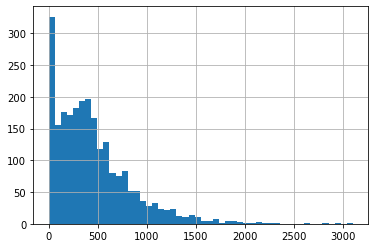

In [11]:
##read data - biomass, Virginia LTER
##Mac:
# df = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_ChristianBlum.csv', skiprows=21)
# df_wq = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_WQ.csv', skiprows=21)

##PC:
df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia_Misc/Virginia_ChristianBlum.csv', skiprows=21)
df_wq = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia_Misc/Virginia_WQ.csv', skiprows=21, \
                    encoding='cp1252') ##Have no idea what's with this encoding argument but it works

##Begin:
df = df[df['speciesName'] == 'Spartina alterniflora'] ##only low marsh and creekbank???

df = df[['EOYBYear', 'collectDate', 'marshName', 'siteName', 'locationID', 'monitoringPurpose', \
         'Transect', 'Replicate', 'speciesName', 'liveMass', 'deadMass', 'totalMass', 'latitude', 'longitude']]

df['collectDate'] = pd.to_datetime(df['collectDate'])

df['liveMass'] = 16 * df['liveMass'] ##look at histograms; is averaging the best way?
df['deadMass'] = 16 * df['deadMass']
df['totalMass'] = 16 * df['totalMass']

locations = [1, 2] ## 1 = creekbank; 2 = low marsh
#df = df[df['locationID'].isin(locations)] ##MOSTLY Spartina alterniflora-only plots; in other zones plots were mixed

df_wq['measureDate'] = pd.to_datetime(df_wq['measureDate'])

max(df['liveMass'])

#df['liveMass'].hist(by=df['siteName'])
df['liveMass'].hist(bins = 50)

##IMPORTANT NOTE: 2017 data does not distinguish live from dead biomass due to a freezer failure

In [ ]:
##summary statistics
df_means = df.groupby('EOYBYear', as_index = False).mean()
df_sem = df.groupby('EOYBYear').sem()

df_means['Year'] = df_means['EOYBYear']
#df.groupby('EOYBYear').aggregate([np.mean, np.size])
#df_means ##'average lat/long' useless
#df_sem

In [ ]:
##grouped by site and by year
mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size, np.std]).reset_index()
se_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).sem()

newdf = df.groupby(['siteName', 'EOYBYear'], as_index = False).mean()

##rearrange lat and long for GEE
mn_siteyears = mn_siteyears[['siteName', 'EOYBYear', 'locationID', 'liveMass', 'longitude', \
                             'latitude', 'deadMass', 'totalMass']]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    #print(mn_siteyears)

#print(se_siteyears)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'outx2.csv')
#se_siteyears.to_csv(out_csv, index=False) ##set out directory

newdf['year'] = newdf['EOYBYear']
print(df)

In [ ]:
##some figures
#df.boxplot(column='liveMass', by='EOYBYear')
#mn_siteyears.boxplot(column='liveMass', by='siteName') ##using averages as individual points

In [3]:
# #my_path = os.path.abspath('/Users/asariversjulien/Documents/Georgia/Project')
# #my_file = 'p1.png'
# #g.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')

print("hi")

hi
